In [105]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import ast

In [106]:
df = pd.read_csv(r'../../data/2022-09-15/listings.csv')

def data_cleanup(df):

    df.dropna(how='all', axis=1, inplace=True) #drop empty cols

    number_looking_strings = ['id', 'scrape_id', 'host_id']
    for col in number_looking_strings:
        df[col] = df[col].astype("string")

    df['host_response_rate'] = df['host_response_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string

    date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format=r'%Y-%m-%d')

    for col in df.columns:
        if df[col][0] == "f" or df[col][0] == "t": #if first record is "t" or "f" we're going to convert to bool - still should spot check after just incase first record of bool is null
            df[col] = df[col].str.replace("f", "0")
            df[col] = df[col].str.replace("t", "1")
            try: ## int can't hold nulls so if the conversion fails due to a value error, convert to float instead
                df[col] = df[col].astype(int)
            except ValueError:
                df[col] = df[col].astype(float)


    remaining_string_cols = df.select_dtypes(include=["object"]).columns #all remaining object columns are strings so I'm explicitly setting them to be
    for col in remaining_string_cols:
        df[col] = df[col].astype('string')

    list_string_cols = ['host_verifications', 'amenities'] #these 2 columns are string lists so I'm converting them back to object just so I remember to handle them differently
    for col in list_string_cols:
        df[col] = df[col].astype('object')

    return df

df = data_cleanup(df)

C:\Users\Neo\AppData\Local\Temp\ipykernel_21552\2211435815.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string


In [107]:
def amenity_feature_engineering(df):
    df['amenities_count'] = 0
    df['amenities_length'] = 0
    df['amenities_avg_length_per_amenity'] = 0.0
    for x in range(0, len(df['amenities'])):
        df['amenities_count'][x] = len(ast.literal_eval(df['amenities'][x]))
        df['amenities_length'][x] = len(df['amenities'][x])
        df['amenities_avg_length_per_amenity'][x] = df['amenities_length'][x]/df['amenities_count'][x]
        if df['amenities_avg_length_per_amenity'][x] == np.inf: #if infinite set to zero
            df['amenities_avg_length_per_amenity'][x] = 0
    return df
df = amenity_feature_engineering(df)

C:\Users\Neo\AppData\Local\Temp\ipykernel_21552\3839507731.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amenities_count'][x] = len(ast.literal_eval(df['amenities'][x]))
C:\Users\Neo\AppData\Local\Temp\ipykernel_21552\3839507731.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amenities_length'][x] = len(df['amenities'][x])
C:\Users\Neo\AppData\Local\Temp\ipykernel_21552\3839507731.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [108]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7733 entries, 0 to 7732
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            7733 non-null   string        
 1   listing_url                                   7733 non-null   string        
 2   scrape_id                                     7733 non-null   string        
 3   last_scraped                                  7733 non-null   datetime64[ns]
 4   source                                        7733 non-null   string        
 5   name                                          7733 non-null   string        
 6   description                                   7691 non-null   string        
 7   neighborhood_overview                         5502 non-null   string        
 8   picture_url                                   7733 non-null   string

In [109]:
drop_list = []
string_cols = df.select_dtypes(include=["object","string"]).columns
for col in string_cols:
    if len(df[col].value_counts()) > 20:
        drop_list.append(col)

print(drop_list, "getting dropped.")
df.drop(columns=drop_list, inplace=True)

['id', 'listing_url', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'bathrooms_text', 'amenities']


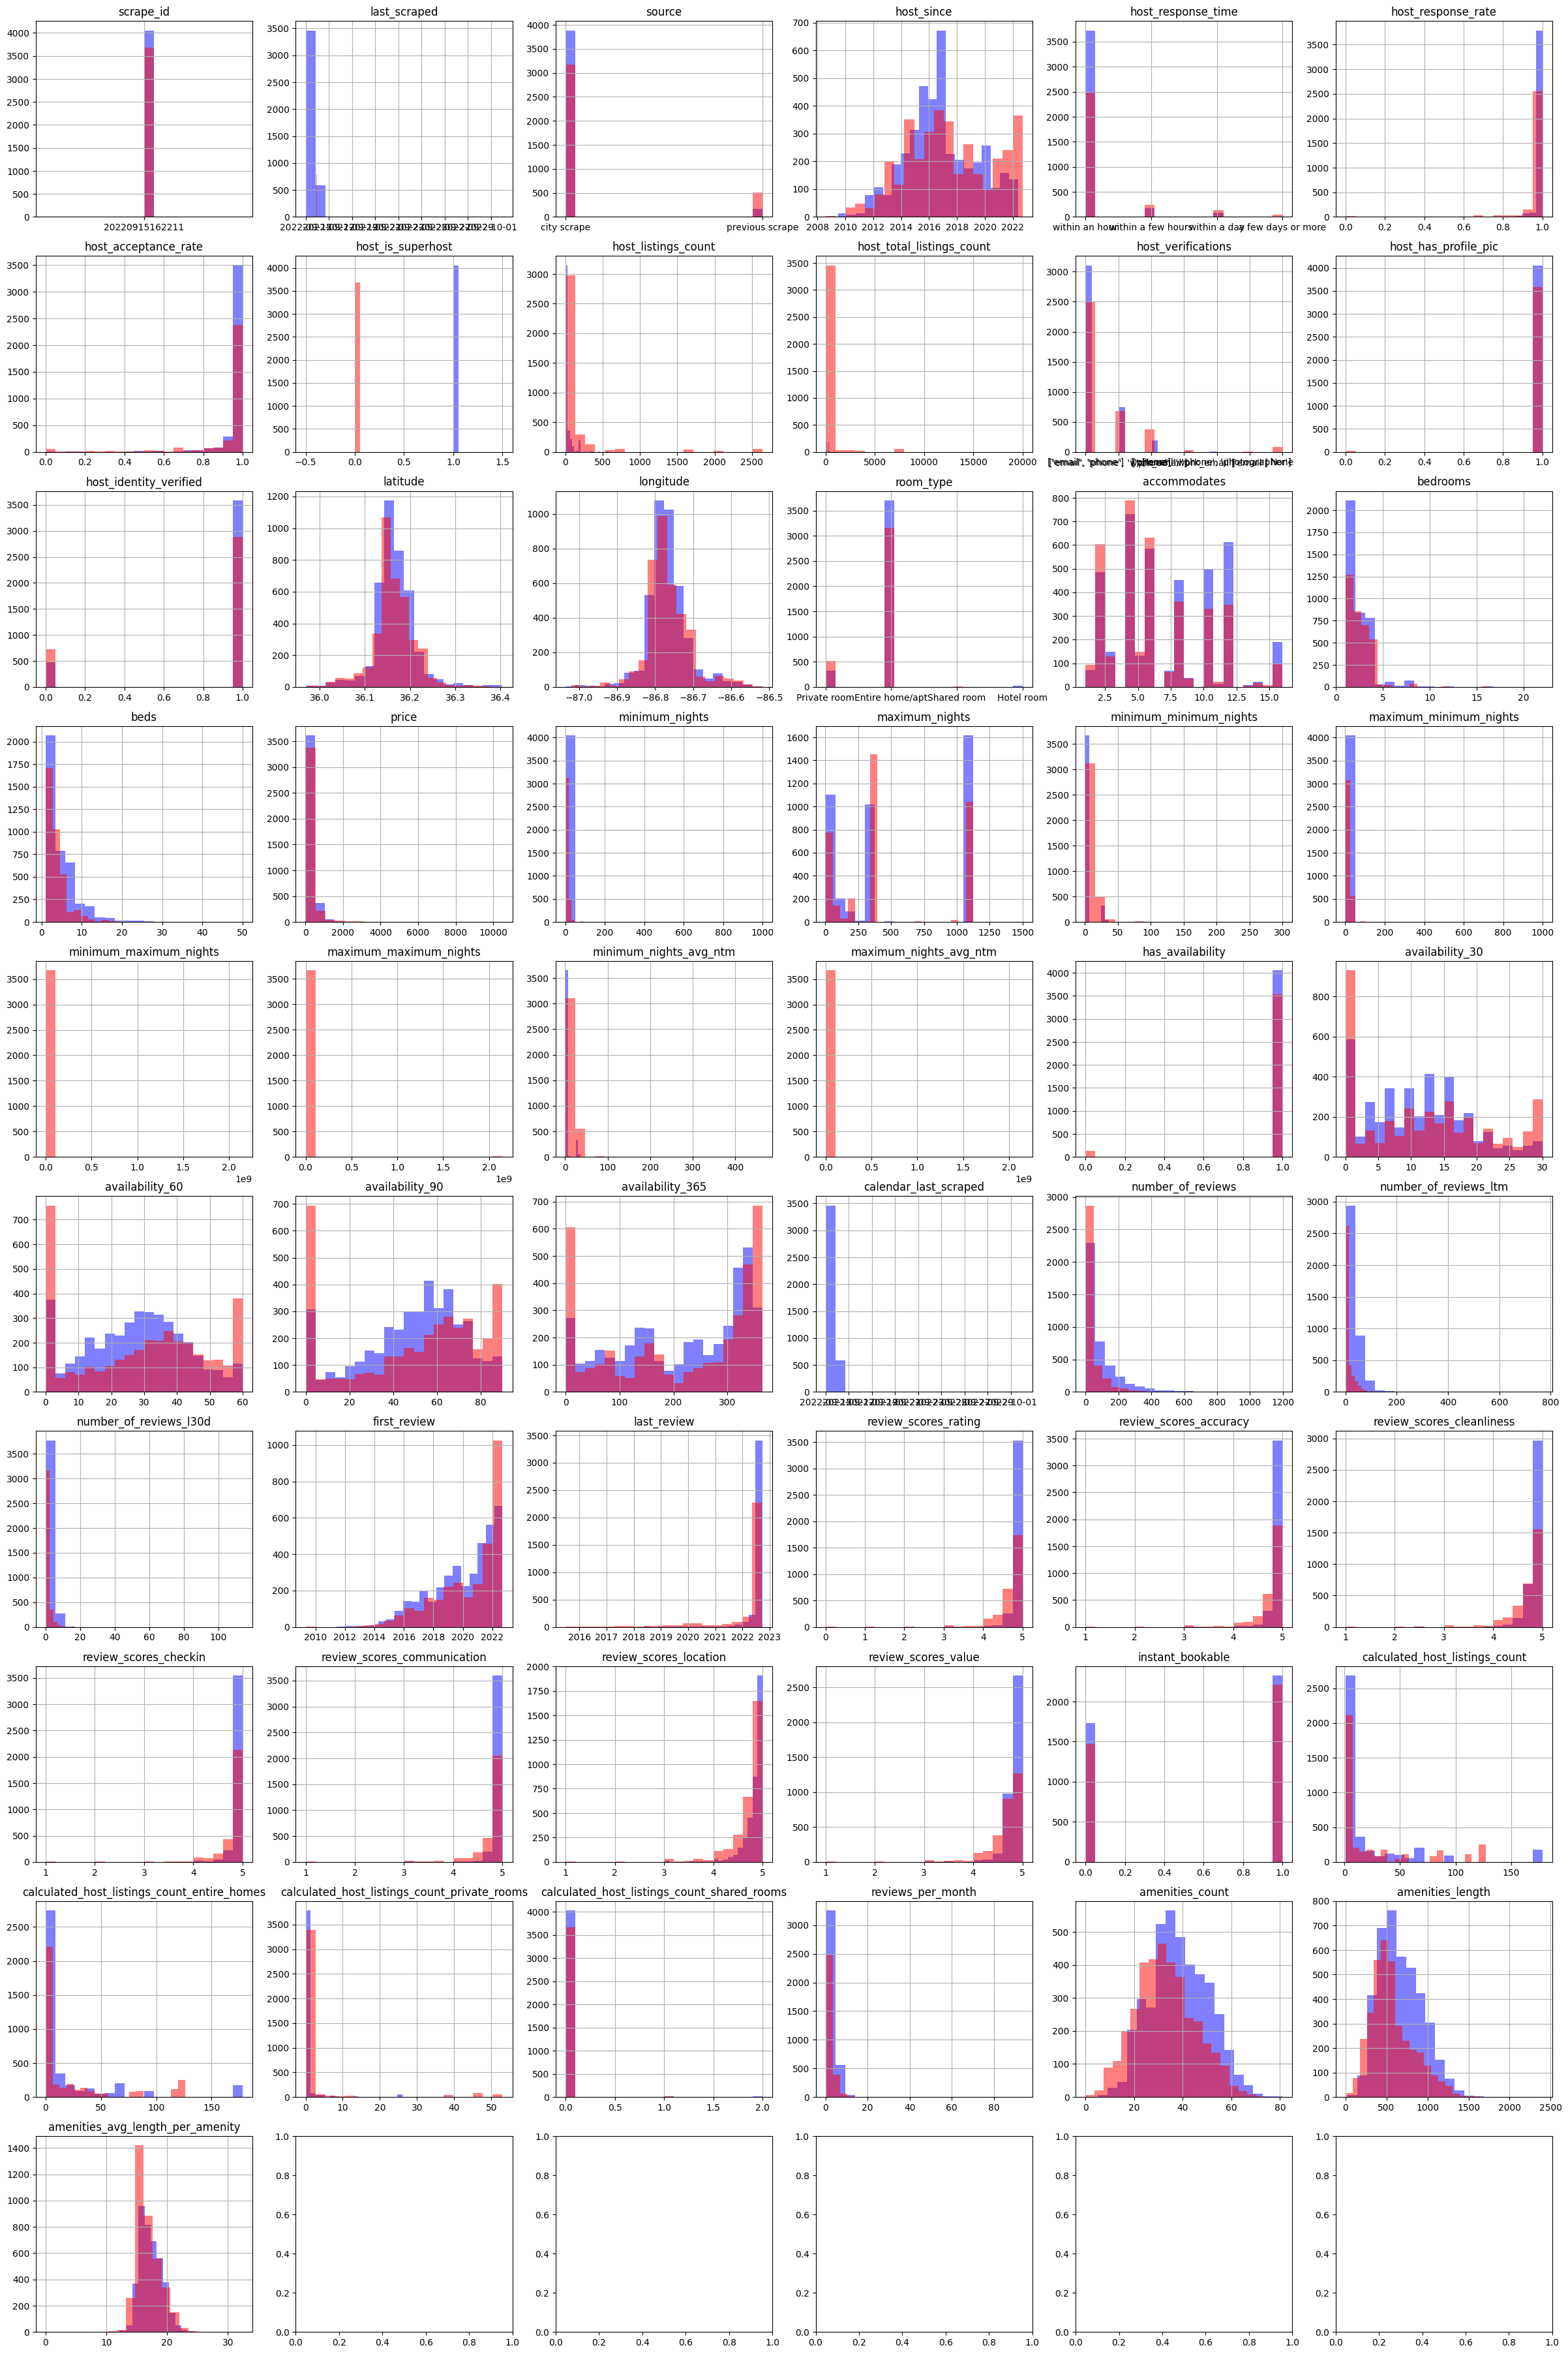

In [111]:
ncols = 6
num_bins = 20
target_col_name = "host_is_superhost"
horizontal_spacing = 0.2

# create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=(len(df.columns)//ncols)+1, ncols=ncols)
fig.set_figheight(5*(len(df.columns)//ncols)+1)
fig.set_figwidth(5 * ncols)
fig.subplots_adjust(hspace=horizontal_spacing)


# loop through each column in your dataframe
for i, col in enumerate(df.columns):
    
    fig_row_num = i // ncols
    fig_col_num = i % ncols

    data1 = df[df[target_col_name] == 1.0][col]
    data2 = df[df[target_col_name] == 0.0][col]

    # check if the column is of type Categorical
    # if df[col].dtype == "string":
    #     axs[fig_row_num][fig_col_num].set_title(col + " (Category)")
    #     data1 = df[df[target_col_name] == 1][col].fillna("NULL")
    #     data2 = df[df[target_col_name] == 0][col].fillna("NULL")
    # else:
    #     if df[col].dtype == "datetime64[ns]":
    #         axs[fig_row_num][fig_col_num].set_title(col + " (Date)")
    #         data1 = df[df[target_col_name] == 1][col].fillna(-2)
    #         data2 = df[df[target_col_name] == 0][col].fillna(-2)
    #     else:
    #         axs[fig_row_num][fig_col_num].set_title(col + " (Numeric)")
    #         data1 = df[df[target_col_name] == 1][col].fillna(-2)
    #         data2 = df[df[target_col_name] == 0][col].fillna(-2)

    # plot the data
    axs[fig_row_num][fig_col_num].set_title(col)
    data1.hist(bins=num_bins, alpha=0.5, color="blue", ax=axs[fig_row_num][fig_col_num])
    data2.hist(bins=num_bins, alpha=0.5, color="red", ax=axs[fig_row_num][fig_col_num])

# show the plots
plt.show()
